In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score

import Levenshtein

In [10]:
ALPHA = 0.5

In [11]:
def calculate_levenshtein_accuracy(true_sentence, generated_sentence):
    distance = Levenshtein.distance(true_sentence, generated_sentence)
    max_len = max(len(true_sentence), len(generated_sentence))
    return 1 - (distance / max_len)

# Calculate BLEU (optional alternative)
def calculate_bleu_score(true_sentence, generated_sentence):
    return sentence_bleu([true_sentence.split()], generated_sentence.split())

def calculate_rouge_scores(true_sentence, generated_sentence):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(true_sentence, generated_sentence)
    rouge_scores = {
        "rouge1": scores['rouge1'].fmeasure,
        "rouge2": scores['rouge2'].fmeasure,
        "rougeL": scores['rougeL'].fmeasure
    }
    return list(rouge_scores.values())

def calculate_meteor_score(true_sentence, generated_sentence):
    # Tokenize sentences
    reference_tokens = true_sentence.split()
    generated_tokens = generated_sentence.split()
    # Calculate METEOR score
    return meteor_score([reference_tokens], generated_tokens)

def combined_score(levenshtein_accuracy, bleu_score, alpha=ALPHA):
    return alpha * levenshtein_accuracy + (1 - alpha) * bleu_score

In [12]:
# test rouge
true_sentence = "The quick brown fox jumps over the lazy dog"
generated_sentence = "The quick brown fox jumps over the lazy dog"
rouge_scores = calculate_rouge_scores(true_sentence, generated_sentence)
print(rouge_scores)

[1.0, 1.0, 1.0]


In [13]:
model_map = {
    'base': 'CoAtNet',
    'llama3_2_1b': 'LLAMA-3.2-1B',
    'llama3_2_3b': 'LLAMA-3.2-3B',
    'llama3_1_8b': 'LLAMA-3.1-8B',
    'gpt-4o': 'GPT-4o',
    # 'echocrypt': 'EchoCrypt',
}

In [14]:
main_dir = '.'

In [15]:
# Data holder for plotting
results = []

for model_dir in os.listdir(main_dir):
    model_path = os.path.join(main_dir, model_dir)
    if os.path.isdir(model_path):
        for csv_file in os.listdir(model_path):
            if csv_file.endswith('.csv'):
                csv_path = os.path.join(model_path, csv_file)
                df = pd.read_csv(csv_path)
                nf = float(csv_file.replace('.csv', ''))
                model_name = model_dir
                # Calculate average accuracy for each CSV (noise factor)
                lev_accuracies = []
                bleu_accuracies = []
                for _, row in df.iterrows():
                    true_sentence = row['True Sentence']
                    predicted_sentence = row['Predicted Sentence']
                    llm_sentence = row['LLM Sentence']
                    
                    base_leven = calculate_levenshtein_accuracy(true_sentence, predicted_sentence)
                    base_bleu = calculate_bleu_score(true_sentence, predicted_sentence)
                    base_combined = combined_score(base_leven, base_bleu)
                    base_meteor = calculate_meteor_score(true_sentence, predicted_sentence)
                    base_rouge1, base_rouge2, base_rougeL = calculate_rouge_scores(true_sentence, predicted_sentence)
                    
                    llm_leven = calculate_levenshtein_accuracy(true_sentence, llm_sentence)
                    llm_bleu = calculate_bleu_score(true_sentence, llm_sentence)
                    llm_combined = combined_score(llm_leven, llm_bleu)
                    llm_meteor = calculate_meteor_score(true_sentence, llm_sentence)
                    llm_rouge1, llm_rouge2, llm_rougeL = calculate_rouge_scores(true_sentence, llm_sentence)
                    
                    results.append({
                        'Model': model_map['base'], # CoAtNet
                        'Noise Factor': nf,
                        'Levenshtein Accuracy': base_leven,
                        'BLEU Accuracy': base_bleu,
                        'Meteor Score': base_meteor,
                        'Rouge-1': base_rouge1,
                        'Rouge-2': base_rouge2,
                        'Rouge-L': base_rougeL,
                        'Adjusted Accuracy': base_combined,
                    })
                    
                    results.append({
                        'Model': model_map[model_name], # LLM
                        'Noise Factor': nf,
                        'Levenshtein Accuracy': llm_leven,
                        'BLEU Accuracy': llm_bleu,
                        'Meteor Score': llm_meteor,
                        'Rouge-1': llm_rouge1,
                        'Rouge-2': llm_rouge2,
                        'Rouge-L': llm_rougeL,
                        'Adjusted Accuracy': llm_combined,
                    })


c:\Users\seyyedaliayati\AppData\Local\anaconda3\envs\rosa\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\seyyedaliayati\AppData\Local\anaconda3\envs\rosa\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\seyyedaliayati\AppData\Local\anaconda3\envs\rosa\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlap

In [16]:
results_df = pd.DataFrame(results)
results_df

,Model,Noise Factor,Levenshtein Accuracy,BLEU Accuracy,Meteor Score,Rouge-1,Rouge-2,Rouge-L,Adjusted Accuracy
0,CoAtNet,1.0,0.980769,6.774546e-01,0.816121,0.838710,0.758621,0.838710,0.829112
1,GPT-4o,1.0,1.000000,1.000000e+00,0.999878,1.000000,1.000000,1.000000,1.000000
2,CoAtNet,1.0,1.000000,1.000000e+00,0.999818,1.000000,1.000000,1.000000,1.000000
3,GPT-4o,1.0,1.000000,1.000000e+00,0.999818,1.000000,1.000000,1.000000,1.000000
4,CoAtNet,1.0,0.936508,3.271093e-78,0.303551,0.352941,0.266667,0.352941,0.468254
...,...,...,...,...,...,...,...,...,...
23995,LLAMA-3.2-3B,6.0,0.576923,4.576103e-78,0.573980,0.666667,0.375000,0.666667,0.288462
23996,CoAtNet,6.0,0.712329,1.348307e-231,0.150000,0.300000,0.000000,0.300000,0.356164
23997,LLAMA-3.2-3B,6.0,0.551282,2.241693e-01,0.474510,0.454545,0.300000,0.454545,0.387726
23998,CoAtNet,6.0,0.739130,5.622823e-155,0.275735,0.333333,0.200000,0.333333,0.369565


In [17]:

results_df = results_df.groupby(['Model', 'Noise Factor']).mean().reset_index()

In [18]:
# re-order models based on model_map.values()
results_df['Model'] = pd.Categorical(results_df['Model'], model_map.values())

In [19]:
results_df

,Model,Noise Factor,Levenshtein Accuracy,BLEU Accuracy,Meteor Score,Rouge-1,Rouge-2,Rouge-L,Adjusted Accuracy
0,CoAtNet,1.0,0.977573,0.571851,0.767764,0.805845,0.683912,0.805845,0.774712
1,CoAtNet,5.0,0.844956,0.023815,0.269136,0.349276,0.128189,0.349276,0.434386
2,CoAtNet,6.0,0.725968,0.001311,0.110302,0.174416,0.031320,0.174416,0.363639
3,GPT-4o,1.0,0.998851,0.990366,0.996265,0.996834,0.993974,0.996834,0.994609
4,GPT-4o,5.0,0.983660,0.920034,0.962308,0.964611,0.937011,0.964457,0.951847
5,GPT-4o,6.0,0.931350,0.756367,0.880803,0.887085,0.810831,0.886946,0.843858
6,LLAMA-3.1-8B,1.0,0.994511,0.972549,0.989593,0.990253,0.981496,0.990253,0.983530
7,LLAMA-3.1-8B,5.0,0.892863,0.668450,0.846061,0.859948,0.758118,0.857777,0.780656
8,LLAMA-3.1-8B,6.0,0.677091,0.260125,0.573243,0.612478,0.415392,0.606682,0.468608
9,LLAMA-3.2-1B,1.0,0.941999,0.844103,0.911688,0.922570,0.886919,0.920935,0.893051


In [20]:
results_df['Noise Factor'] = results_df['Noise Factor'].astype(str)


In [21]:
# Separate data for each plot
def plot_accuracy(df, accuracy_type):
    plt.figure(figsize=(10, 6))
    for model in model_map.values():
        model_data = df[df['Model'] == model]
        plt.plot(model_data['Noise Factor'], model_data[accuracy_type], marker='o', label=model)
        # print model, nf, accuracy_type, accuracy
        print(f"Base Model: Zoom, Model: {model}, NF: {model_data['Noise Factor'].values}, {accuracy_type}: {model_data[accuracy_type].values}")

    plt.xlabel('Noise Factor', fontweight='bold')
    plt.ylabel(f'{accuracy_type}', fontweight='bold')
    plt.title(f'Zoom Model', fontweight='bold') # (alpha={ALPHA})
    
    # Bold tick numbers
    # plt.xticks(fontweight='bold')
    # plt.yticks(fontweight='bold')
    
    plt.legend()
    plt.savefig(f'{accuracy_type.replace(' ', '_').replace('-', '_')}_zoom.pdf', format='pdf')
    plt.show()

Base Model: Zoom, Model: CoAtNet, NF: ['1.0' '5.0' '6.0'], BLEU Accuracy: [0.57185056 0.02381515 0.00131065]
Base Model: Zoom, Model: LLAMA-3.2-1B, NF: ['1.0' '5.0' '6.0'], BLEU Accuracy: [0.84410272 0.28834761 0.05440913]
Base Model: Zoom, Model: LLAMA-3.2-3B, NF: ['1.0' '5.0' '6.0'], BLEU Accuracy: [0.94869819 0.55063835 0.17492825]
Base Model: Zoom, Model: LLAMA-3.1-8B, NF: ['1.0' '5.0' '6.0'], BLEU Accuracy: [0.97254861 0.66844968 0.26012499]
Base Model: Zoom, Model: GPT-4o, NF: ['1.0' '5.0' '6.0'], BLEU Accuracy: [0.99036629 0.92003355 0.7563671 ]


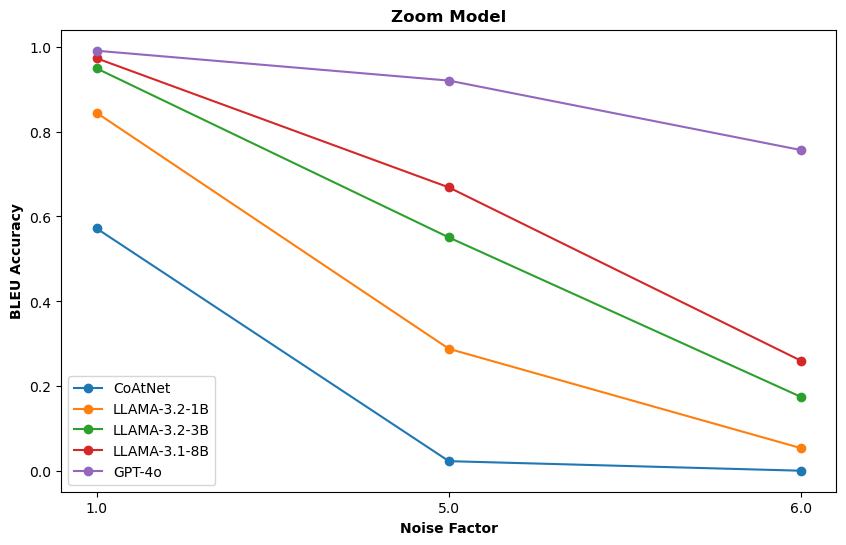

Base Model: Zoom, Model: CoAtNet, NF: ['1.0' '5.0' '6.0'], Meteor Score: [0.76776377 0.26913551 0.11030214]
Base Model: Zoom, Model: LLAMA-3.2-1B, NF: ['1.0' '5.0' '6.0'], Meteor Score: [0.9116877  0.54822882 0.23557671]
Base Model: Zoom, Model: LLAMA-3.2-3B, NF: ['1.0' '5.0' '6.0'], Meteor Score: [0.97752289 0.77900857 0.47807516]
Base Model: Zoom, Model: LLAMA-3.1-8B, NF: ['1.0' '5.0' '6.0'], Meteor Score: [0.98959324 0.84606064 0.573243  ]
Base Model: Zoom, Model: GPT-4o, NF: ['1.0' '5.0' '6.0'], Meteor Score: [0.99626502 0.9623078  0.88080334]


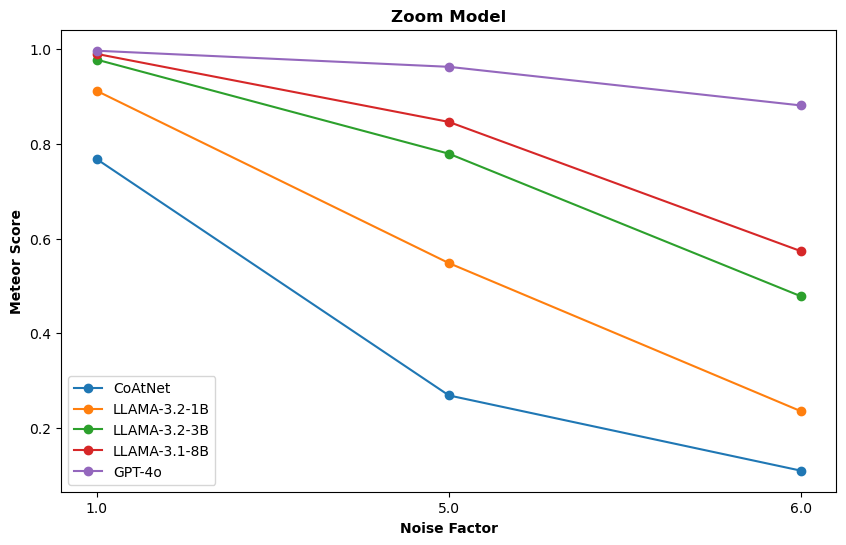

Base Model: Zoom, Model: CoAtNet, NF: ['1.0' '5.0' '6.0'], Rouge-1: [0.80584495 0.34927586 0.17441625]
Base Model: Zoom, Model: LLAMA-3.2-1B, NF: ['1.0' '5.0' '6.0'], Rouge-1: [0.92256973 0.58399873 0.28851458]
Base Model: Zoom, Model: LLAMA-3.2-3B, NF: ['1.0' '5.0' '6.0'], Rouge-1: [0.97902111 0.79714578 0.52933571]
Base Model: Zoom, Model: LLAMA-3.1-8B, NF: ['1.0' '5.0' '6.0'], Rouge-1: [0.99025337 0.85994784 0.61247819]
Base Model: Zoom, Model: GPT-4o, NF: ['1.0' '5.0' '6.0'], Rouge-1: [0.99683433 0.96461104 0.88708485]


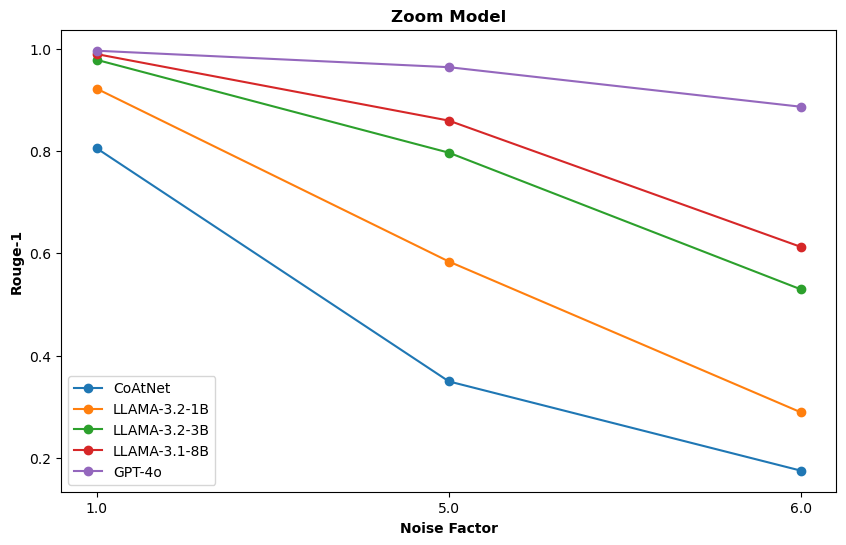

Base Model: Zoom, Model: CoAtNet, NF: ['1.0' '5.0' '6.0'], Rouge-2: [0.68391164 0.12818867 0.03131999]
Base Model: Zoom, Model: LLAMA-3.2-1B, NF: ['1.0' '5.0' '6.0'], Rouge-2: [0.8869188  0.41469822 0.13153307]
Base Model: Zoom, Model: LLAMA-3.2-3B, NF: ['1.0' '5.0' '6.0'], Rouge-2: [0.9643672  0.66463749 0.31861998]
Base Model: Zoom, Model: LLAMA-3.1-8B, NF: ['1.0' '5.0' '6.0'], Rouge-2: [0.98149577 0.75811829 0.41539225]
Base Model: Zoom, Model: GPT-4o, NF: ['1.0' '5.0' '6.0'], Rouge-2: [0.99397421 0.93701096 0.81083134]


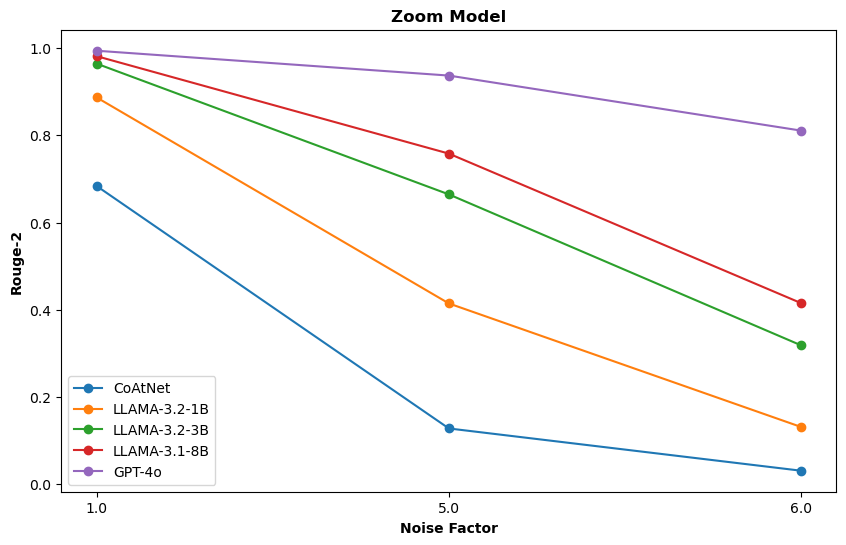

Base Model: Zoom, Model: CoAtNet, NF: ['1.0' '5.0' '6.0'], Rouge-L: [0.80584495 0.34927586 0.17441625]
Base Model: Zoom, Model: LLAMA-3.2-1B, NF: ['1.0' '5.0' '6.0'], Rouge-L: [0.92093476 0.57806909 0.28311425]
Base Model: Zoom, Model: LLAMA-3.2-3B, NF: ['1.0' '5.0' '6.0'], Rouge-L: [0.97902111 0.79501485 0.52321167]
Base Model: Zoom, Model: LLAMA-3.1-8B, NF: ['1.0' '5.0' '6.0'], Rouge-L: [0.99025337 0.85777678 0.60668202]
Base Model: Zoom, Model: GPT-4o, NF: ['1.0' '5.0' '6.0'], Rouge-L: [0.99683433 0.96445719 0.88694596]


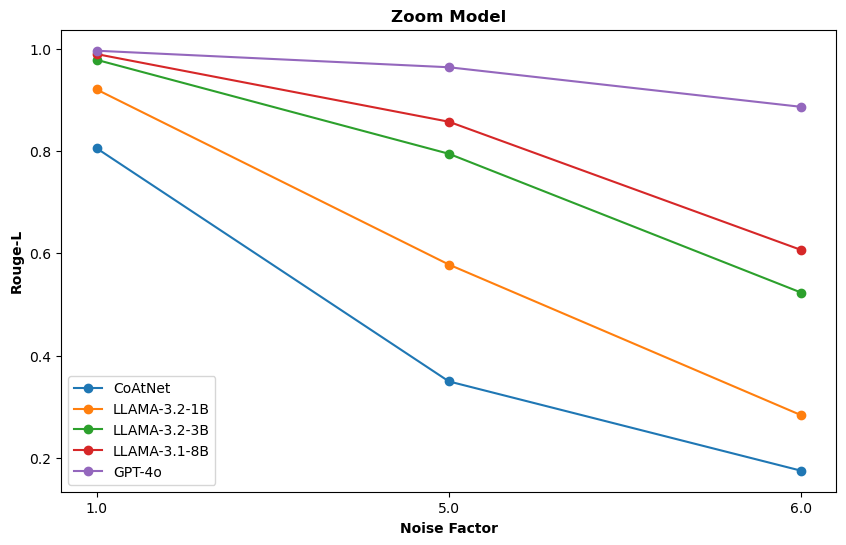

In [22]:
# Plot Levenshtein Accuracy
# plot_accuracy(results_df, 'Levenshtein Accuracy')

# Plot BLEU Accuracy
plot_accuracy(results_df, 'BLEU Accuracy')

# Plot Combined Accuracy
# plot_accuracy(results_df, 'Adjusted Accuracy')

# Plot Meteor Score
plot_accuracy(results_df, 'Meteor Score')

# Plot Rouge-1
plot_accuracy(results_df, 'Rouge-1')

# Plot Rouge-2
plot_accuracy(results_df, 'Rouge-2')

# Plot Rouge-L
plot_accuracy(results_df, 'Rouge-L')